## Rolling Cross Validation for Monthly CPI Forecasting

In this notebook, using Prophet, we provide a template for a rolling cross validation experiment on a CPI forecasting task. The purpose of rolling cross validation, in this context, is to evaluate how well the strategy of consuming all available data for model training would have worked in retrospect. This can be useful in situations where data are scarce and where it is desirable to train models using the most recently available data possible.

To do this, we will refit a Prophet model using data up to several cutoff dates. In this notebook, we use 6 cutoff dates that are all one year apart. This code has been adapted from Vector's contribution to the 2022 edition of Canada's Food Price Report, with code available [here](https://github.com/VectorInstitute/foodprice-forecasting).

In [20]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
pd.set_option('precision', 3)
from prophet import Prophet
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import os

In [21]:
"""
Set the output path corresponding to the experiment. The ensembling experiment will 
look for specific output files in the output directory corresponding to forecasts, 
e.g.: ./output/prophet_202110/forecasts_2015-07-01.csv
"""
output_path = "./rolling_cv_output/prophet_experiment"
if not os.path.exists(output_path):
    if not os.path.exists("./rolling_cv_output"):
        os.mkdir("./rolling_cv_output")
    os.mkdir(output_path)

## Load Data From File

In this demo, we will use Prophet to produce univarate forecasts for each of the 9 major Canadian food price categories listed in the columns below. The dataset is part of a larger dataset that includes many variables from the [FRED](https://fred.stlouisfed.org/) database. These variables are not used in this demo, but could certainly be used in an exploration of more sophisticated global or multivariate forecasting models!

If we're using Colab, we mount our Google Drive which should have the bootcamp datasets in it already (See Github Repo Readme for instructions).

In [ ]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

`data_dir` should be changed to reflect the address of the cpi_forecasting dataset. For example, if using Colab, the dataset may be housed in `/content/drive/MyDrive/Forecasting Bootcamp`. 

In [22]:
data_dir = "/ssd003/projects/forecasting_bootcamp/bootcamp_datasets/cpi_forecasting"
foodprice_categories = pd.read_csv(f"{data_dir}/foodprice_categories.txt", sep='\n', header=None)[0].to_list()
foodprice_df = pd.read_csv(f"{data_dir}/all_data.csv", index_col=0)
foodprice_df = foodprice_df.set_index(pd.DatetimeIndex(foodprice_df.index))
foodprice_df

,Bakery and cereal products (excluding baby food),Dairy products and eggs,"Fish, seafood and other marine products",Food purchased from restaurants,Food,"Fruit, fruit preparations and nuts",Meat,Other food products and non-alcoholic beverages,Vegetables and vegetable preparations,DEXCAUS,...,XTIMVA01CAM657S,XTIMVA01CAM659S,XTIMVA01CAM664N,XTIMVA01CAM664S,XTIMVA01CAM667S,XTNTVA01CAM664N,XTNTVA01CAM664S,XTNTVA01CAM667S,TOTALNS,TOTALSL
1986-01-01,69.3,70.9,60.6,59.1,67.3,76.0,65.1,77.5,76.0,1.392,...,3.644,12.051,9.368e+09,9.496e+09,6.749e+09,6.906e+08,1.052e+09,7.479e+08,607.369,605.703
1986-02-01,70.3,70.8,61.3,59.1,66.9,77.6,64.2,78.1,68.4,1.392,...,1.965,16.745,9.495e+09,9.632e+09,6.881e+09,-9.880e+07,1.539e+08,1.099e+08,605.807,610.678
1986-03-01,70.6,71.1,61.3,59.3,67.0,79.2,64.2,78.6,66.2,1.392,...,-11.565,1.655,8.803e+09,8.529e+09,6.085e+09,9.138e+08,9.079e+08,6.478e+08,606.799,613.377
1986-04-01,71.3,71.0,61.4,59.7,67.7,82.2,63.6,79.5,71.1,1.392,...,13.334,10.821,1.034e+10,9.569e+09,6.897e+09,3.470e+08,6.563e+08,4.730e+08,614.367,619.658
1986-05-01,71.2,71.4,61.9,59.9,68.2,83.5,64.0,79.8,75.3,1.377,...,-4.236,6.160,9.598e+09,9.091e+09,6.605e+09,7.013e+08,6.893e+08,5.008e+08,621.915,625.820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-01,157.7,145.3,146.2,163.9,156.8,144.5,176.7,142.2,153.4,1.203,...,-1.087,31.561,5.159e+10,4.979e+10,4.075e+10,3.661e+09,3.111e+09,2.546e+09,4259.604,4307.137
2021-07-01,157.9,146.4,146.6,165.2,157.6,141.7,180.9,141.9,154.8,1.240,...,1.990,18.580,5.106e+10,5.205e+10,4.156e+10,3.780e+08,1.129e+09,9.018e+08,4276.202,4323.730
2021-08-01,158.5,148.3,146.8,165.9,158.0,142.5,182.1,141.7,152.2,1.251,...,-2.312,14.723,5.245e+10,5.115e+10,4.060e+10,1.300e+09,2.674e+09,2.123e+09,4316.303,4337.489
2021-09-01,158.1,148.0,147.1,165.9,158.5,141.5,184.8,144.3,150.0,1.262,...,-3.461,8.557,5.080e+10,4.965e+10,3.920e+10,1.561e+09,2.277e+09,1.798e+09,4346.662,4367.402


## Experiment Setup

Load the rolling cross validation cutoff dates specified in a file.

In [4]:
cutoff_dates = pd.read_csv(f"{data_dir}/cutoff_dates.txt", sep='\n', header=None)[0].to_list()
cutoff_dates

['2015-07-01',
 '2016-07-01',
 '2017-07-01',
 '2018-07-01',
 '2019-07-01',
 '2020-07-01']

Use the cutoff dates to determine collections of training and validation periods that correspond to the cutoff date. In this case, the task is to train using all data available up to the cutoff date, and to evaluate forecasts on the following 18 months only. This is a direct reflection of this specific use case, where we are only ever interested in producing 18-month forecasts on an annual basis. 

In [23]:
sim_train_dates = {}
sim_valid_dates = {}

for date in cutoff_dates:
    sim_train_dates[date] = foodprice_df.index[foodprice_df.index <= date]
    sim_valid_dates[date] = foodprice_df.index[(foodprice_df.index > date) & (foodprice_df.index <= (pd.to_datetime(date) + pd.DateOffset(months=18)))]

### Helper Function for Prophet Data Loading

In [7]:
def get_prophet_df(foodprice_df, food_category, dates):
    df = foodprice_df[food_category][dates]
    df = df.reset_index()
    df = df.rename({'REF_DATE':'ds', 'index':'ds', food_category:'y'}, axis=1)
    return df

### Define Evaluation Metrics

In [8]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

metrics = {
    'r2_score': r2_score,
    'mae': mean_absolute_error,
    'mape': mean_absolute_percentage_error,
    'mse': mean_squared_error,
    'rmse': rmse
}

## Define Functions to Fit and Evaluate Models for All CPI Categories (Validation)

The following function will fit and evaluate a Prophet model for a single food price category using the specified training and validation dates

In [9]:
def fit_eval_forecast_model(foodprice_df, food_category, train_dates, valid_dates):
    train_df = get_prophet_df(foodprice_df, food_category, train_dates)     # Select training data.
    model = Prophet()                                                       # Initialize model with (default) paramters.
    model.fit(train_df)                                                     # Fit the model.
    valid_df = get_prophet_df(foodprice_df, food_category, valid_dates)     # Select the validation data. 
    valid_forecast = model.predict(valid_df[['ds']])                        # Produce the validation period forecast. 

    valid_metrics = {metric_name: metric_fn(y_true=valid_df.y,              # Compute validation metrics. 
                                      y_pred=valid_forecast.yhat) for metric_name, metric_fn in metrics.items()}

    return model, valid_forecast, valid_metrics

In [10]:
def plot_valid_forecast(model, food_category, sim_forecast_date, valid_forecast, valid_actual):

    fig = model.plot(valid_forecast, figsize=(10,4))
    ax = fig.axes[0]
    ax.scatter(valid_actual.ds, valid_actual.y, color='green', s=10, label='Actual CPI')
    ax.set_title(f'CPI Forecast (Simulated From {date}) - {food_category}')
    ax.set_ylabel('CPI (% of 2002 Baseline)')
    ax.set_xlabel('Date')

    ### Creating legend elements
    cmap = plt.get_cmap("tab10")
    handles, labels = ax.get_legend_handles_labels()
    actual_patch = Line2D([0], [0], color='w', markerfacecolor='black', marker='o', label='Historical CPI')
    fc_patch = mpatches.Patch(color=cmap(0), label='Predicted CPI Uncertainty', alpha=0.5)
    fc_line = Line2D([0], [0], color=cmap(0), label='Predicted CPI')
    handles.append(actual_patch)
    handles.append(fc_line)
    handles.append(fc_patch)
    ax.legend(handles=handles)
    plt.savefig(f"{output_path}/fc_valid_{food_category}_{sim_forecast_date}.svg", bbox_inches='tight')
    plt.savefig(f"{output_path}/fc_valid_{food_category}_{sim_forecast_date}.png", bbox_inches='tight')
    plt.show()

### Run model fitting and evaluation

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.7612
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1313.02     0.0112517        744.71          10           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1358.12     0.0176746       1365.67          10           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1367.85    0.00364334        793.92           1           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1376.37    0.00168705       212.183           1           1      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1378.68    0.00108347       238.119           1           1      582   
    Iter      log prob        ||dx||      ||grad||       alpha   

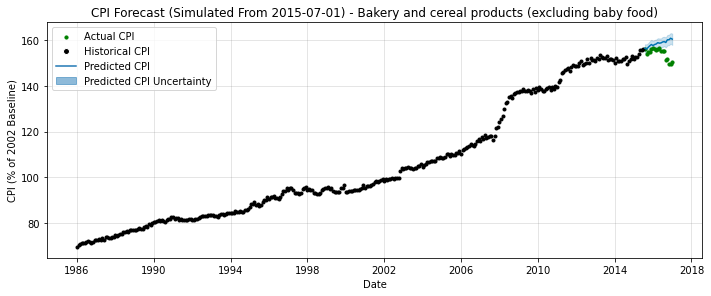

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -4.439
mae          4.432
mape         0.029
mse         31.430
rmse         5.606
dtype: float64
Initial log joint probability = -2.59973
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1368.34     0.0124114        1820.9           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1405.96    0.00322224       436.898           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1412.85    0.00473256        307.23           1           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1417.63   0.000840383       276.719         2.1        0.21      466   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1420.85   0.000127083     

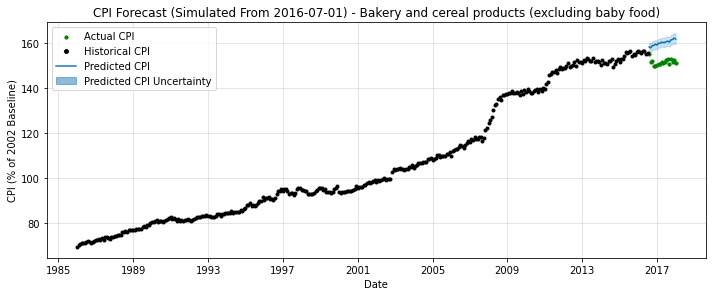

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -43.828
mae          8.565
mape         0.057
mse         76.268
rmse         8.733
dtype: float64
Initial log joint probability = -2.48661
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1392.29    0.00727217       163.699           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1409.01    0.00110231       665.933       0.663       0.663      218   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1417.41    0.00470497       378.655           1           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1420.41      0.021434       333.863           1           1      457   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     469       1426.01   7.82124e-05     

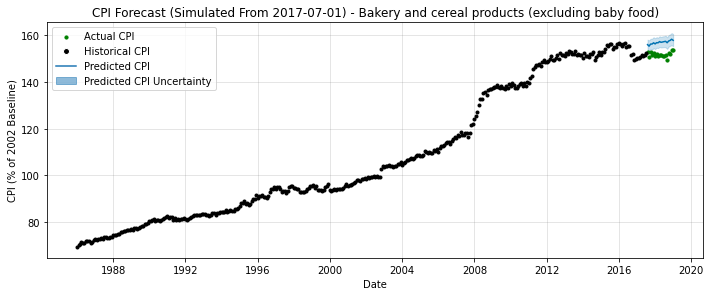

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -25.176
mae          5.110
mape         0.034
mse         27.072
rmse         5.203
dtype: float64
Initial log joint probability = -2.50119
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1427.31    0.00176279       435.658           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1458.12    0.00164051       165.088      0.2705           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1477.24    0.00147014       404.293      0.8605      0.8605      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1491.54    0.00887189       711.971           1           1      445   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     473       1493.26   6.55034e-05     

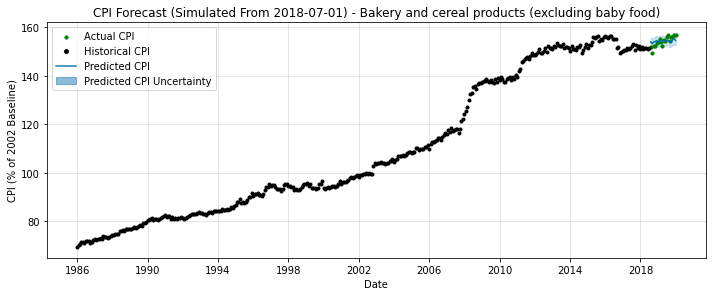

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    0.274
mae         1.413
mape        0.009
mse         2.897
rmse        1.702
dtype: float64
Initial log joint probability = -2.48641
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1502.69     0.0036483       702.218           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1531.72     0.0145236       1093.03      0.2404           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1545.14    0.00141053       1009.21      0.1572      0.1572      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1553.68     0.0013836       234.069     0.09427           1      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1556.42    0.00103611       331

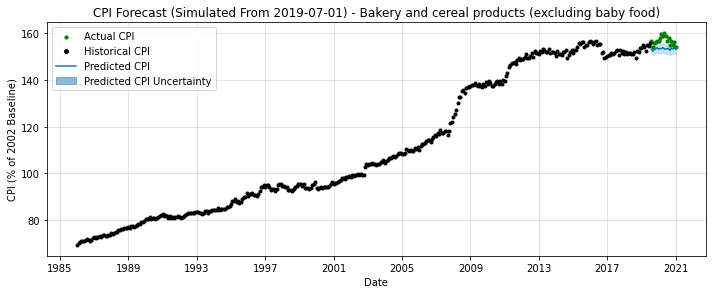

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -4.556
mae          3.606
mape         0.023
mse         15.227
rmse         3.902
dtype: float64
Initial log joint probability = -2.47511
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1561.68     0.0140137       496.107           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1578.4    0.00212304       1218.95           1           1      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1591.7   0.000680982       194.226      0.1439           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1594.04    0.00190597       372.842           1           1      471   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     494       1604.94   7.76096e-05     

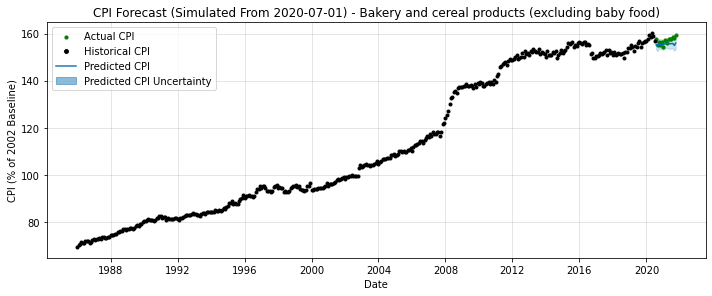

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -0.987
mae         1.599
mape        0.010
mse         3.606
rmse        1.899
dtype: float64
Initial log joint probability = -2.27694
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1505.15     0.0070654       3336.99           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1550.49    0.00118283       968.975      0.2897           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1561.34     0.0120008       1678.86           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1568.76    0.00902522       500.778      0.9345      0.9345      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1570.99   0.000478782       218

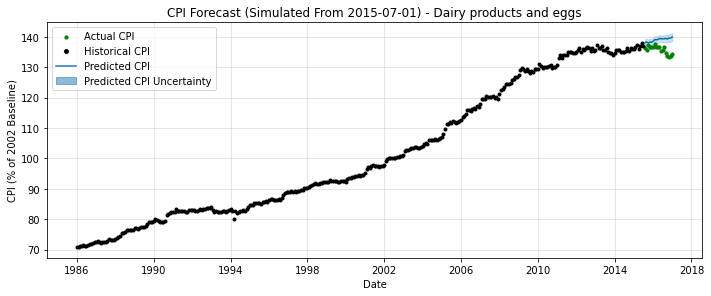

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -6.674
mae          3.156
mape         0.023
mse         12.918
rmse         3.594
dtype: float64
Initial log joint probability = -2.27357
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1584.73     0.0320163          3438          10           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1604.16    0.00201618        1835.3      0.1722      0.1722      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299          1619   0.000996835        468.99      0.2825           1      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1624.09   0.000548223       223.838           1           1      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     473       1626.29   2.23009e-05     

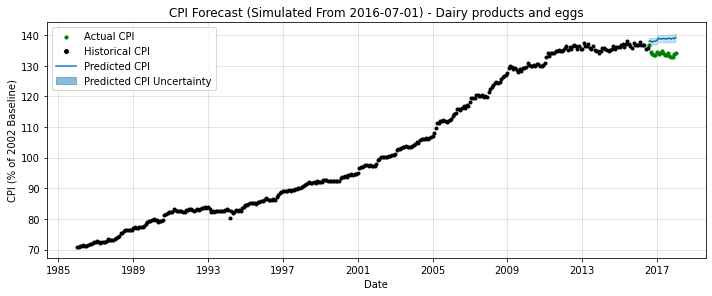

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -29.771
mae          4.621
mape         0.035
mse         22.539
rmse         4.747
dtype: float64
Initial log joint probability = -2.37705
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1607.51    0.00166785       1189.01           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1640.58     0.0950866       7147.88      0.6073           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1652.68     0.0152327       733.596           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1660.7     0.0013613       1223.08           1           1      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     475       1662.75   1.95666e-05     

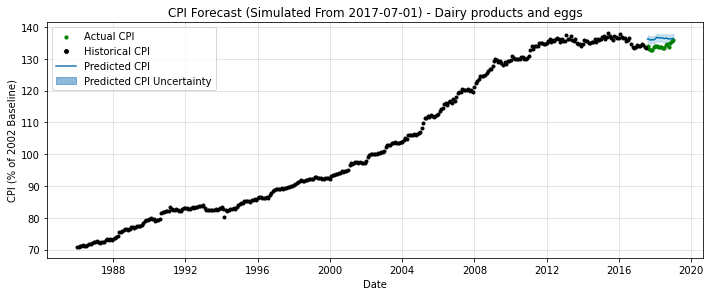

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -8.011
mae         2.390
mape        0.018
mse         6.368
rmse        2.523
dtype: float64
Initial log joint probability = -2.4619
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99          1665    0.00139805       833.927           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1701.12   0.000348409       379.704           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1727.04     0.0201037       2922.33           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1746.28   0.000669101       421.571           1           1      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     449       1749.12   1.21148e-05       209.

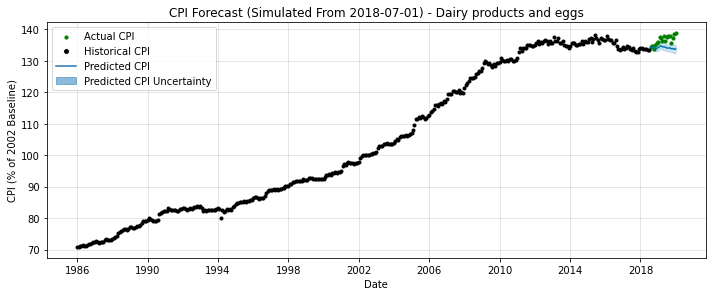

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -2.619
mae         2.415
mape        0.018
mse         7.983
rmse        2.825
dtype: float64
Initial log joint probability = -2.37086
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1734.42     0.0230712       5491.12           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1762.28   0.000853831       543.692           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1774.49    0.00634037       744.125       1.022      0.1022      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1779.85    0.00140215        467.18           1           1      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1787.89   0.000314145       925

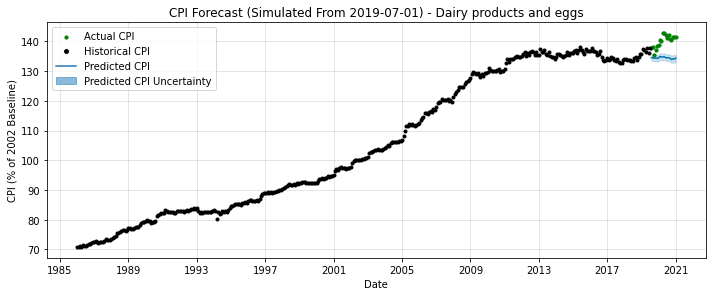

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -7.825
mae          5.749
mape         0.041
mse         37.129
rmse         6.093
dtype: float64
Initial log joint probability = -2.31087
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1699.41    0.00183016       829.299           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1734.53   0.000801917       301.174           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1740.52   0.000115772       140.139       0.798       0.798      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1742.77    0.00993633       311.617           1           1      444   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     448       1744.83   4.48823e-05     

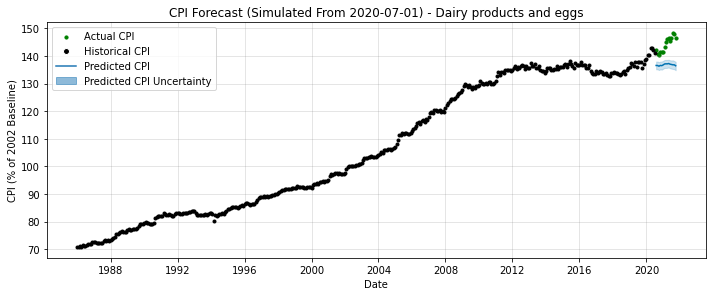

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -7.877
mae          7.431
mape         0.051
mse         61.418
rmse         7.837
dtype: float64
Initial log joint probability = -2.39071
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1267.69    0.00287224       346.504           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1287.19     0.0242984        314.98           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1291.88   0.000147383       87.0775      0.6981      0.6981      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1296.07    0.00420773        349.04           1           1      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1298.16   4.98431e-05     

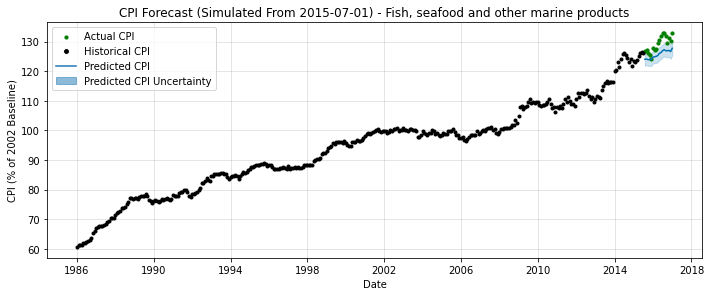

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -1.069
mae          3.539
mape         0.027
mse         14.875
rmse         3.857
dtype: float64
Initial log joint probability = -2.52016
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1319.8    0.00674462       323.641           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1345.33    0.00434279       288.167      0.2254           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     287       1352.22    0.00048106       219.672   4.978e-06       0.001      383  LS failed, Hessian reset 
     299       1352.99    0.00591281       197.557           1           1      396   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1356.75      0.025413       316.767           1           1      513   
    Iter      log prob

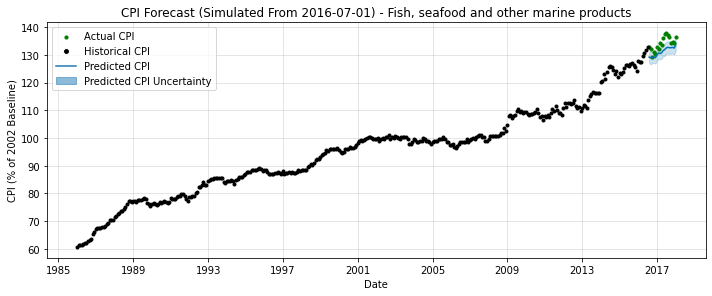

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -0.776
mae          2.958
mape         0.022
mse         10.787
rmse         3.284
dtype: float64
Initial log joint probability = -2.63227
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1393.23    0.00848298       569.212           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1427.18     0.0200556       523.541           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1433.24    0.00298923       465.885           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     379       1437.95   0.000173234       220.445   3.911e-07       0.001      476  LS failed, Hessian reset 
     399       1438.99    0.00104971       120.644       0.952       0.952      496   
    Iter      log prob

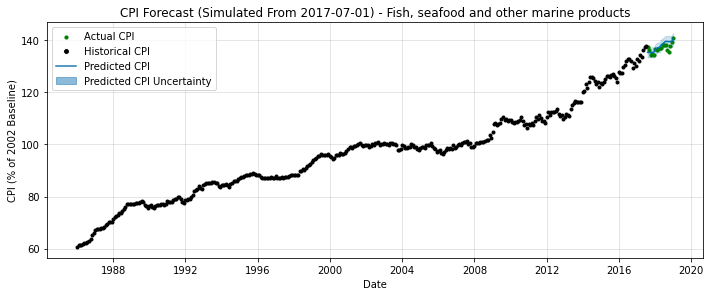

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    0.184
mae         1.116
mape        0.008
mse         2.198
rmse        1.483
dtype: float64
Initial log joint probability = -2.51039
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1454.74        0.0151       205.467           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1489.07    0.00259201         181.8           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1501.25    0.00623449       614.228           1           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1511.42     0.0132344       337.104           1           1      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        1515.5    0.00632804       415

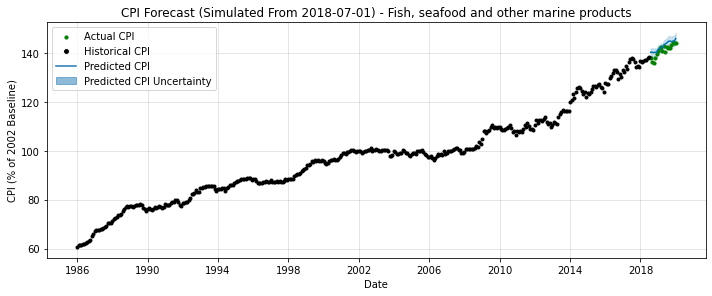

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    0.296
mae         1.725
mape        0.012
mse         4.615
rmse        2.148
dtype: float64
Initial log joint probability = -2.56655
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1530.06     0.0230833       422.406           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1559.35     0.0242799       1423.32           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1570.47    0.00155673       190.774           1           1      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     334       1572.51    3.5928e-05       223.009   1.918e-07       0.001      433  LS failed, Hessian reset 
     399       1573.99    0.00107352       84.7948           1           1      508   
    Iter      log prob     

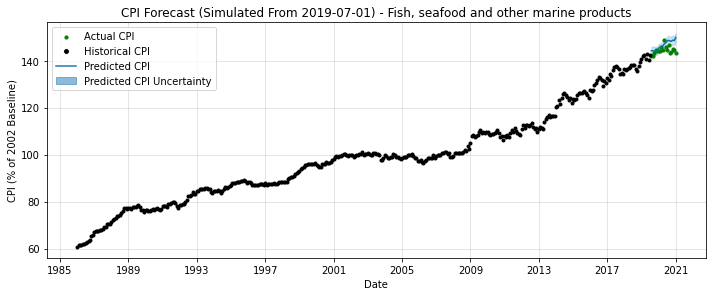

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -2.410
mae         2.418
mape        0.017
mse         8.884
rmse        2.981
dtype: float64
Initial log joint probability = -2.50884
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1570.35     0.0146366       1854.58           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1609.92    0.00247811       2175.71      0.6263      0.6263      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1620.83     0.0013585       925.976      0.6147      0.6147      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     385        1626.8   4.26607e-05       164.694   2.641e-07       0.001      483  LS failed, Hessian reset 
     399       1627.18   0.000100424       338.605      0.6388      0.6388      498   
    Iter      log prob     

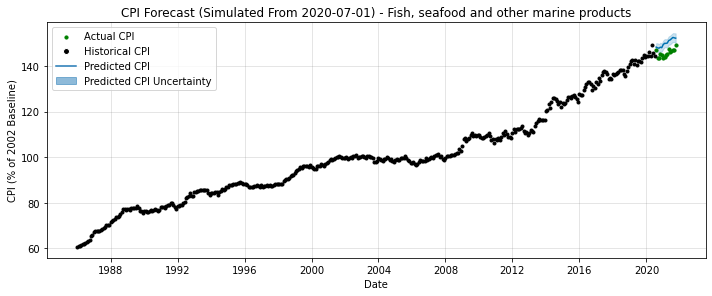

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -6.386
mae          4.381
mape         0.030
mse         20.787
rmse         4.559
dtype: float64
Initial log joint probability = -2.0862
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1640.02   0.000552856       1362.22      0.1532      0.1532      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1712.6   0.000484073        890.82      0.3633      0.3633      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1733.56    0.00242051        2117.5           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1749.29   0.000957189       983.436           1           1      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1760.47   0.000144428      

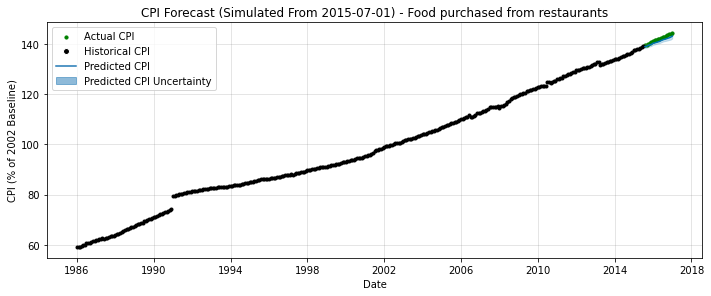

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    0.548
mae         0.973
mape        0.007
mse         1.026
rmse        1.013
dtype: float64
Initial log joint probability = -2.09869
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1687.38      0.048712       3874.91           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1769.63    0.00189755       1632.48           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1816.35     0.0034367       2034.73           1           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1820.68    0.00149283       1003.04       0.395       0.395      457   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1839.01    0.00246921       513

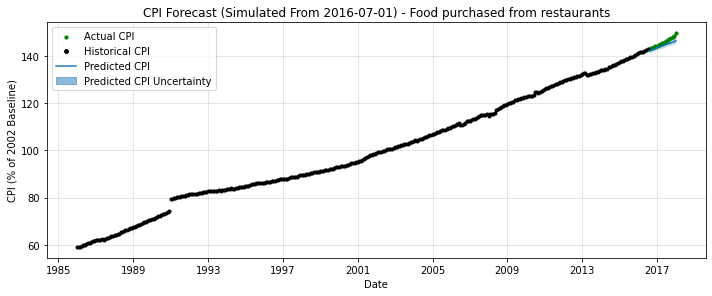

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    0.306
mae         1.419
mape        0.010
mse         2.427
rmse        1.558
dtype: float64
Initial log joint probability = -2.11409
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1766.9     0.0241364       2982.21           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1841.24    0.00884535       4520.38      0.5604      0.5604      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1868.21   0.000330366       357.773           1           1      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1879.89    0.00260576       3508.38           1           1      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1885.12    0.00357189       173

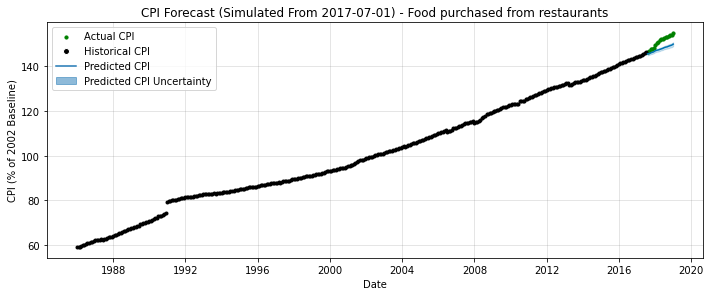

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -1.009
mae          3.468
mape         0.023
mse         13.898
rmse         3.728
dtype: float64
Initial log joint probability = -2.21958
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1756.9    0.00209452       1671.98           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1827.92    0.00256497       1179.08      0.9605      0.9605      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1856.76    0.00917324       2015.76           1           1      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1864.78   0.000679352       736.068           1           1      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1868.89   0.000931314     

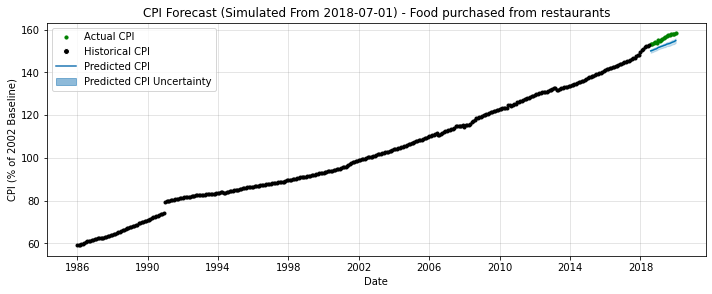

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -3.015
mae          3.441
mape         0.022
mse         11.993
rmse         3.463
dtype: float64
Initial log joint probability = -2.25413
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1830.76    0.00232023       3618.97      0.2118      0.2118      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1871.67   0.000243986       738.488       0.342       0.342      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1881.34    0.00335488       1943.62           1           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1904.74   0.000187638       459.835           1           1      446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        1911.1    0.00145356     

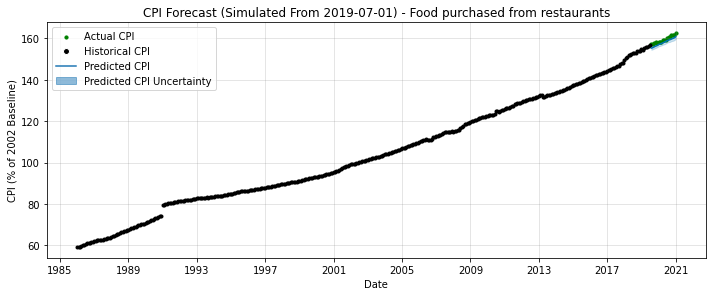

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    0.150
mae         1.441
mape        0.009
mse         2.226
rmse        1.492
dtype: float64
Initial log joint probability = -2.25978
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1899.22    0.00104876       6015.75     0.02341           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1968.74    0.00383425       753.688           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1982.84   0.000282777       275.266           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        2024.9    0.00195563       2538.15      0.2974      0.8678      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2036.37    0.00624295        13

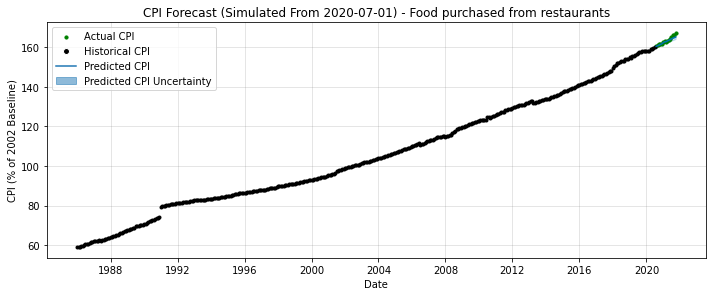

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    0.842
mae         0.519
mape        0.003
mse         0.576
rmse        0.759
dtype: float64
Initial log joint probability = -2.33711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1579.67    0.00338153       709.059           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1613.66   0.000284282       483.673           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1620.46    0.00227242       448.198           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1625.39    0.00448424       630.081           1           1      457   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1627.94   0.000415379       660

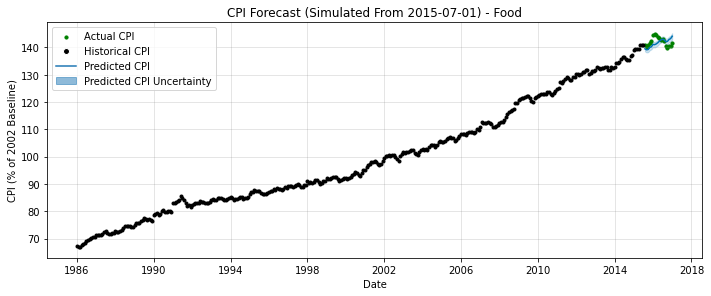

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -0.855
mae         1.892
mape        0.013
mse         4.721
rmse        2.173
dtype: float64
Initial log joint probability = -2.31054
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1631.84    0.00697427       1651.73           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1647.59    0.00917791        2584.2           1           1      222   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1658.95    0.00614898        785.74           1           1      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1662.87   0.000212551         346.9           1           1      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1665.02   0.000552678       398

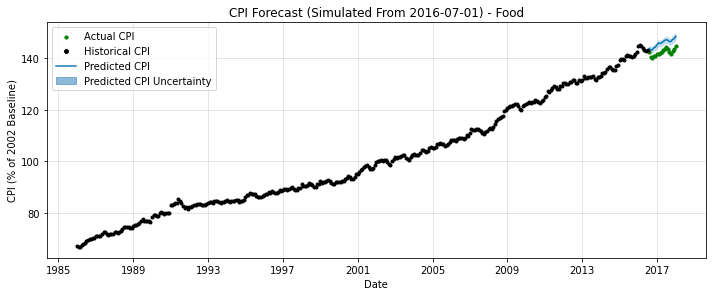

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -6.298
mae          3.494
mape         0.025
mse         12.700
rmse         3.564
dtype: float64
Initial log joint probability = -2.2499
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1662.49    0.00547885       1079.87           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1667.72    0.00361662       1122.26           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1674.58    0.00116823       251.283           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1676.84   0.000231371       141.556           1           1      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     413          1677   1.11878e-05      

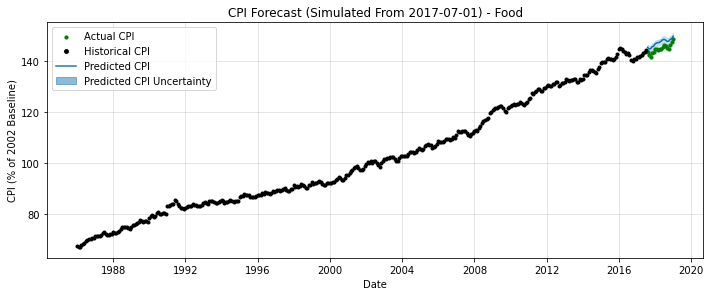

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -1.091
mae         2.350
mape        0.016
mse         5.875
rmse        2.424
dtype: float64
Initial log joint probability = -2.23278
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1698.31    0.00452877       1631.02           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1712.11     0.0144166       1104.86           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1719.12    0.00032261       243.028           1           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1723.45   0.000666493       257.121      0.6427      0.6427      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1725.13    0.00026934       196

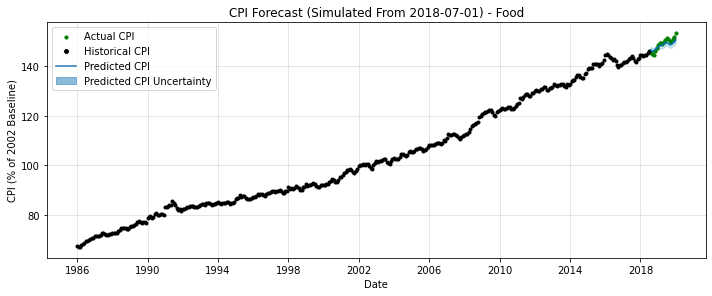

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    0.675
mae         1.238
mape        0.008
mse         1.916
rmse        1.384
dtype: float64
Initial log joint probability = -2.3316
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1764.73   0.000221592       1783.16      0.5572      0.5572      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1784.85    0.00664774       1027.11           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1788.88     0.0029187       502.815      0.4175           1      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1792.6    0.00448077       1179.16           1           1      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1796.66   0.000473105       155.

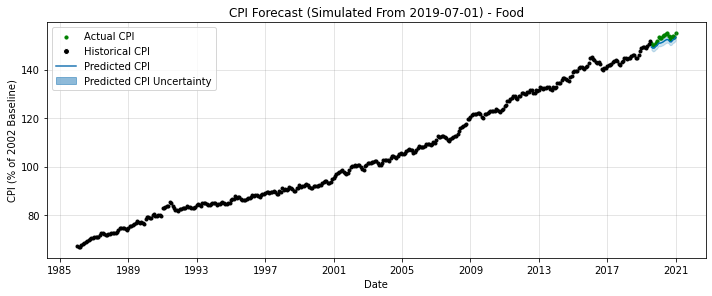

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -0.667
mae         1.902
mape        0.012
mse         3.905
rmse        1.976
dtype: float64
Initial log joint probability = -2.3579
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1810.17    0.00176286        809.91      0.7928      0.7928      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1830.05    0.00124601       1562.38      0.4604           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1839.07   0.000825722       247.788           1           1      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     393       1842.15    1.7188e-05       254.249   4.919e-08       0.001      484  LS failed, Hessian reset 
     399       1842.27     0.0017329       1133.01           1           1      490   
    Iter      log prob      

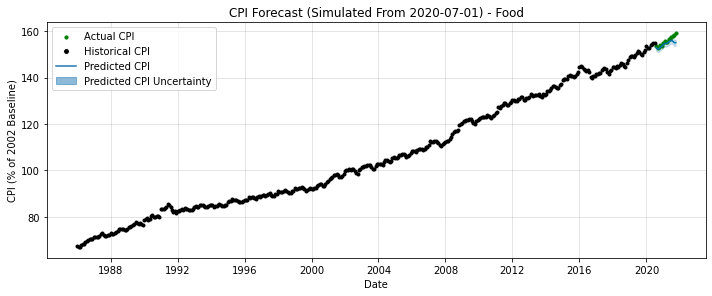

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    0.248
mae         1.316
mape        0.008
mse         2.921
rmse        1.709
dtype: float64
Initial log joint probability = -2.90205
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1130.46    0.00903131       813.959           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1133.47    0.00807861       199.249           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       1133.68   0.000217271       118.544   2.128e-06       0.001      286  LS failed, Hessian reset 
     299       1134.69    0.00244054       168.408      0.8903      0.8903      396   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     308       1135.15   0.000177224       187.161   7.935e-07       0.001      453  LS failed, Hessian reset 
   

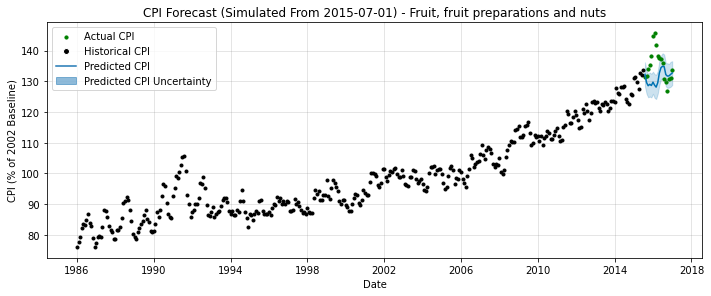

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -1.229
mae          5.628
mape         0.041
mse         56.858
rmse         7.540
dtype: float64
Initial log joint probability = -2.79024
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1175.39    0.00452611       122.299           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     196       1179.86   0.000508153       169.086   4.719e-06       0.001      275  LS failed, Hessian reset 
     199       1179.94   0.000292576       146.696           1           1      278   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1180.64   0.000107501        69.643      0.4203      0.4203      406   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1180.73   0.000114582       64.2224      0.6073      0.6073      524   
    Iter      log prob

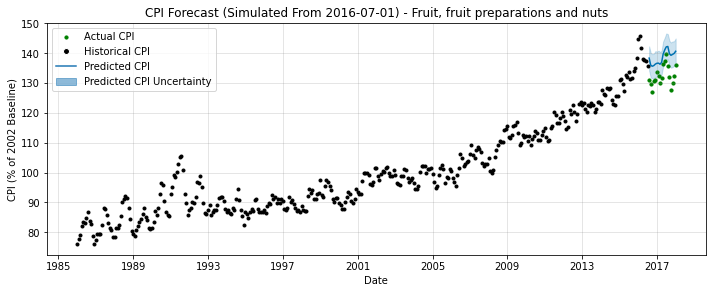

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -2.851
mae          6.046
mape         0.046
mse         42.199
rmse         6.496
dtype: float64
Initial log joint probability = -2.9315
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       1211.13   0.000108646       109.701   5.579e-07       0.001      167  LS failed, Hessian reset 
      99       1211.13   4.68473e-05       89.8652           1           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1213.75   0.000493866       126.929           1           1      287   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       1214.31   0.000113193       121.333   1.175e-06       0.001      375  LS failed, Hessian reset 
     246       1214.49   0.000669269       192.044   1.274e-05       0.001      429  LS failed, Hessian reset 
     294        1214.6    0.00028559        243.51   2.995e-06     

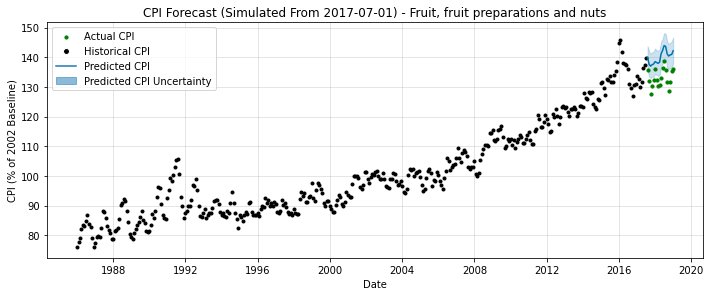

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -4.973
mae          6.922
mape         0.052
mse         52.542
rmse         7.249
dtype: float64
Initial log joint probability = -2.73356
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1241.03   0.000350951       93.2991      0.3427      0.3427      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135       1242.31   9.20886e-05       96.3213   6.408e-07       0.001      206  LS failed, Hessian reset 
     199       1243.87    0.00124895       145.531           1           1      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       1244.64   0.000154953        137.48   1.213e-06       0.001      351  LS failed, Hessian reset 
     299       1245.16    0.00364556       114.096           1           1      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes

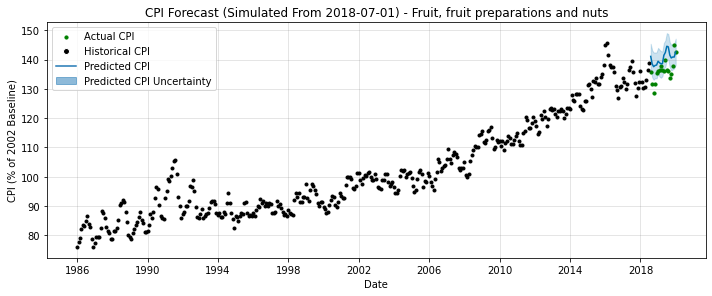

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -1.147
mae          4.659
mape         0.035
mse         28.352
rmse         5.325
dtype: float64
Initial log joint probability = -2.51446
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1274.46   0.000254995       108.467        0.61        0.61      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1278.25   0.000427368       86.4109           1           1      263   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     235       1278.62   0.000213261        219.83   1.325e-06       0.001      339  LS failed, Hessian reset 
     299       1279.13   8.97659e-05       100.137           1           1      429   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     339       1279.59   0.000131012       147.122   8.299e-07       0.001      512  LS failed, Hessian reset

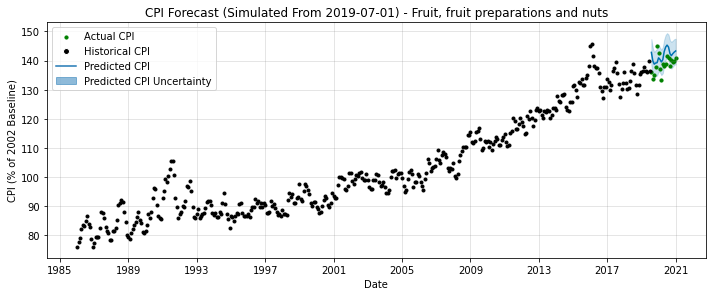

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -1.016
mae          3.755
mape         0.027
mse         17.056
rmse         4.130
dtype: float64
Initial log joint probability = -2.69346
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1309.37   0.000647428       91.4524           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1314.21    0.00125984       105.674           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     278       1315.87   0.000165679         168.2   5.671e-07       0.001      383  LS failed, Hessian reset 
     299       1316.51   0.000869569       94.2743      0.2581           1      408   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     376       1317.16   0.000140921       163.298   1.138e-06       0.001      562  LS failed, Hessian reset

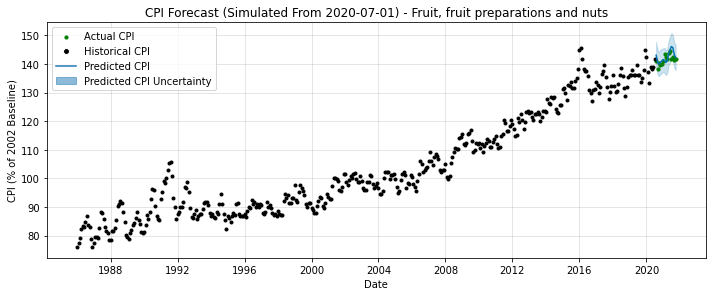

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -0.395
mae         1.543
mape        0.011
mse         3.715
rmse        1.927
dtype: float64
Initial log joint probability = -3.52442
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1281.14    0.00846668       978.266           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1291.32    0.00549562       452.459           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1295.59    0.00043103       299.288      0.4869      0.4869      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     388       1297.77   9.91075e-05        261.26   2.609e-07       0.001      532  LS failed, Hessian reset 
     399       1298.39   0.000571444       353.171       0.451       0.451      544   
    Iter      log prob     

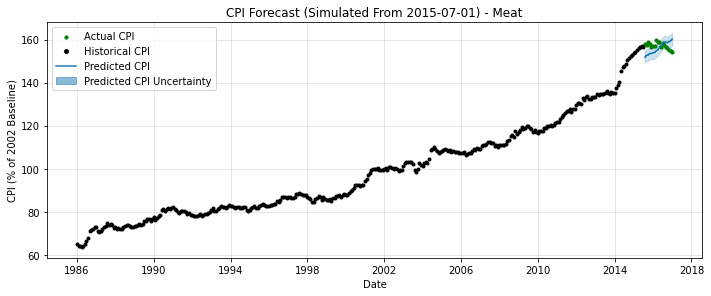

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -5.709
mae          3.503
mape         0.022
mse         15.230
rmse         3.903
dtype: float64
Initial log joint probability = -3.3323
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1338.88    0.00238961       378.642           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1357.06      0.049655        1903.2           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1362.77    0.00197808       238.125           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1366.04    0.00125758       412.613           1           1      457   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1369.94    0.00107414      

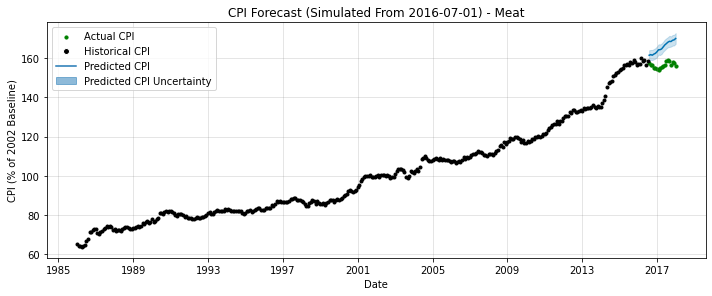

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -40.942
mae          9.075
mape         0.058
mse         88.509
rmse         9.408
dtype: float64
Initial log joint probability = -3.07077
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1359.95    0.00608256       427.373           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1366.04   0.000448673       171.509      0.9195      0.9195      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     287        1367.6    8.7663e-05       216.892   2.937e-07       0.001      392  LS failed, Hessian reset 
     299       1367.84   0.000585541       165.575     0.08613           1      407   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     382       1368.52   8.12882e-05       175.307   4.677e-07       0.001      556  LS failed, Hessian reset

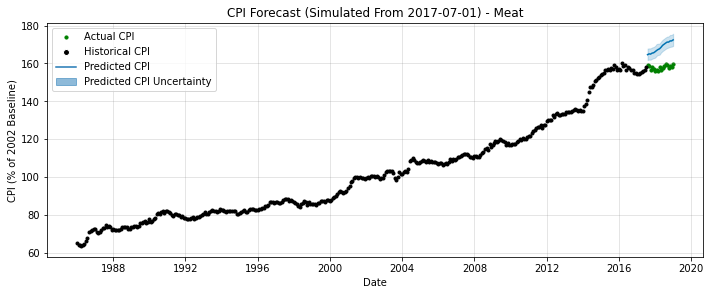

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -78.791
mae          10.492
mape          0.066
mse         115.709
rmse         10.757
dtype: float64
Initial log joint probability = -2.88274
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1358.7    0.00466687       266.295           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     176       1362.62   6.46626e-05       91.3135   2.445e-07       0.001      275  LS failed, Hessian reset 
     199       1363.89   0.000504694       163.122           1           1      302   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     287       1364.84   3.60922e-05       77.8795   3.317e-07       0.001      448  LS failed, Hessian reset 
     299       1364.86   8.85661e-05       64.9892           1           1      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  

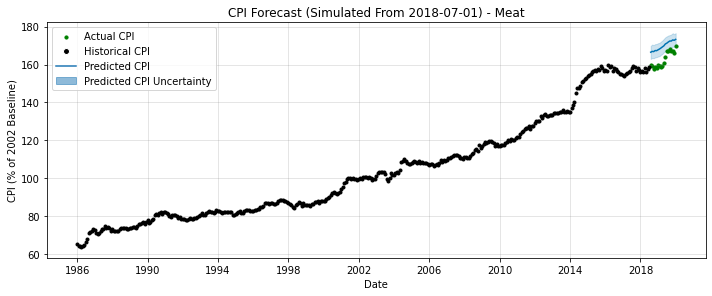

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -2.244
mae          7.133
mape         0.044
mse         55.204
rmse         7.430
dtype: float64
Initial log joint probability = -3.2237
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1395.08    0.00438099       116.957           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       1397.94   0.000153659       80.4366   1.529e-06       0.001      235  LS failed, Hessian reset 
     199       1398.48   0.000477391       129.983           1           1      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1400.58    0.00321427       91.3273      0.3416           1      405   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1401.72   2.54024e-05       49.7826      0.2204      0.2204      522   
    Iter      log prob 

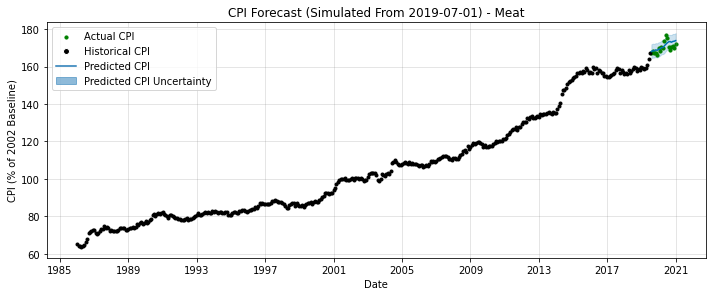

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    0.196
mae         2.092
mape        0.012
mse         6.403
rmse        2.530
dtype: float64
Initial log joint probability = -3.5247
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1466.47     0.0127928        1224.7           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     191       1476.35   5.11199e-05       108.991   4.454e-07       0.001      281  LS failed, Hessian reset 
     199       1476.45    0.00147579       141.862       3.831      0.3831      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1478.93    0.00598578       265.333      0.5019      0.5019      412   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     324       1479.72   0.000100285        90.982   7.705e-07       0.001      488  LS failed, Hessian reset 
    

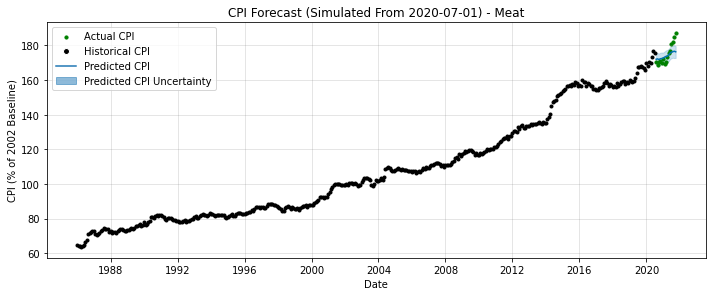

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score     0.439
mae          3.341
mape         0.019
mse         19.451
rmse         4.410
dtype: float64
Initial log joint probability = -2.2565
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1321.93     0.0167177       457.279           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1348.76    0.00221558         239.6           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1358.07   0.000127427        129.38           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1362.66    0.00245433       957.929      0.2632      0.2632      456   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     428       1367.85    0.00021921      

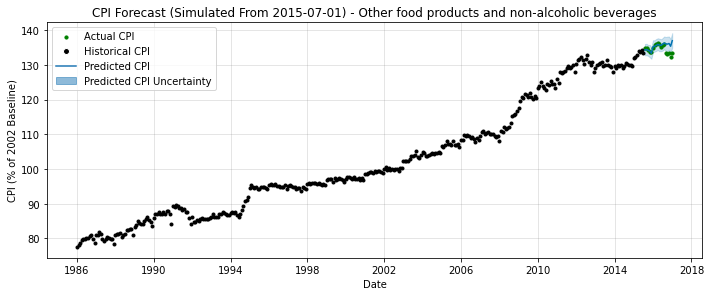

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -0.857
mae         1.080
mape        0.008
mse         2.661
rmse        1.631
dtype: float64
Initial log joint probability = -2.26887
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1404.38     0.0365899       1551.59           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1446.56   0.000395571        125.98           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1453.36   0.000797742       316.781           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1461.34    0.00039122       224.085           1           1      456   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1464.02    0.00131972       793

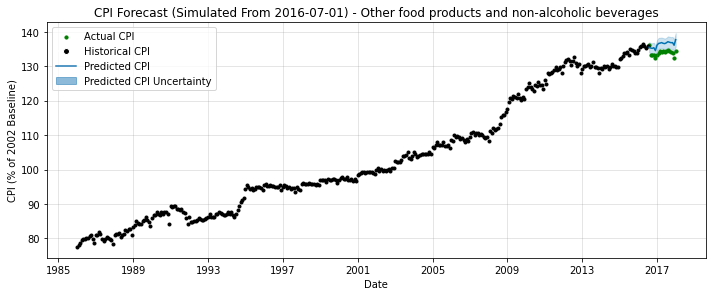

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -8.206
mae         2.477
mape        0.019
mse         6.521
rmse        2.554
dtype: float64
Initial log joint probability = -2.18937
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1451.22    0.00154569       627.588      0.2401      0.9714      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1495.3    0.00289364       602.389      0.5316      0.5316      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1516.23   0.000107544       136.249           1           1      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1521.88   0.000339802       232.388           1           1      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499          1527    0.00140278       699

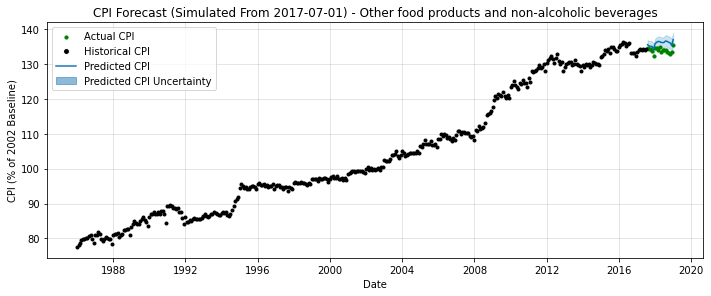

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -7.940
mae         1.962
mape        0.015
mse         4.372
rmse        2.091
dtype: float64
Initial log joint probability = -2.17846
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1507.46    0.00216447       950.765      0.3756      0.3756      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1546.93     0.0224297       1494.39           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1560.69    0.00820925       1613.14           1           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1574.09    0.00904279       1545.31           1           1      457   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1578.59   0.000115276       164

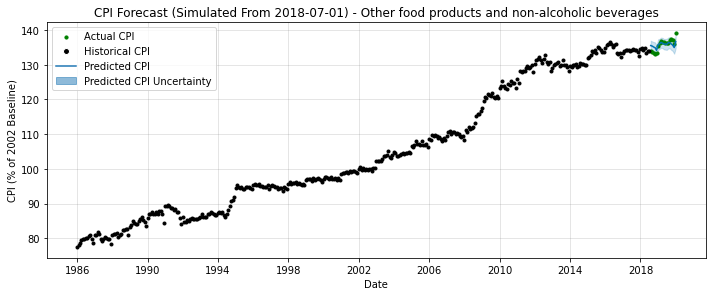

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    0.468
mae         0.949
mape        0.007
mse         1.402
rmse        1.184
dtype: float64
Initial log joint probability = -2.17779
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1547.01     0.0311082       3185.51           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1590.17    0.00140629       434.367           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1608.67    0.00513202       1236.77      0.7784      0.7784      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1619.09   0.000432502       224.683      0.9931      0.9931      444   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1623.31     0.0174544       135

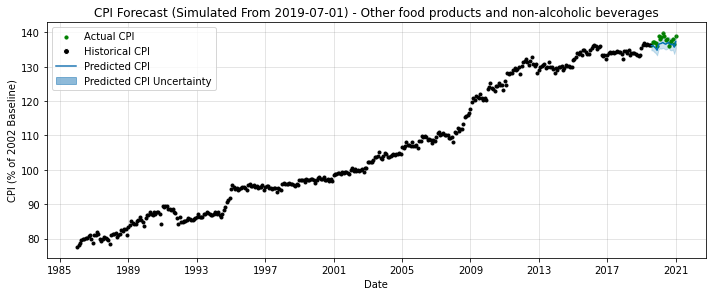

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -0.932
mae         1.389
mape        0.010
mse         2.375
rmse        1.541
dtype: float64
Initial log joint probability = -2.17091
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1620.25     0.0382145       1015.89           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1663.15     0.0326621       2407.41           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1677.6    0.00137644        314.45           1           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1683.16    0.00119065       208.788           1           1      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        1686.9    0.00456866       639

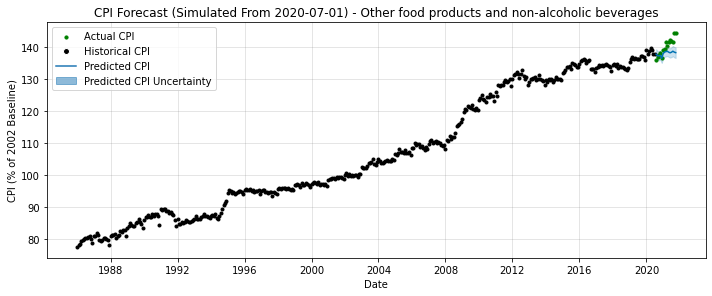

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score   -0.315
mae         2.346
mape        0.017
mse         9.028
rmse        3.005
dtype: float64
Initial log joint probability = -3.86358
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       961.972    0.00648327       99.4519      0.2681           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       962.859   0.000379414       102.759   1.408e-06       0.001      222  LS failed, Hessian reset 
     199       963.367   2.95597e-05        52.018           1           1      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     227       963.368   1.02618e-08       68.8073      0.1747      0.1747      334   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


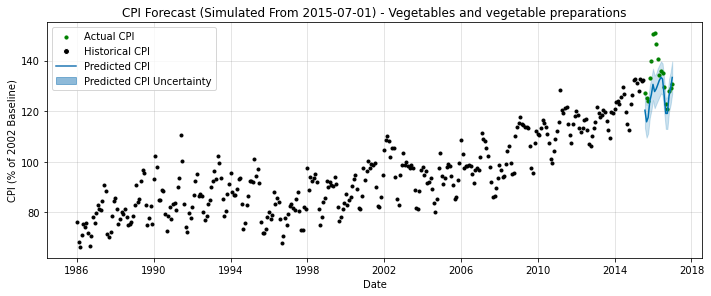

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score     -0.302
mae           7.595
mape          0.055
mse         102.481
rmse         10.123
dtype: float64
Initial log joint probability = -3.5538
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1025.63    0.00144776       96.2095           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1027.35   0.000360103       73.2427      0.3609      0.3609      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       1027.38   9.06536e-05       63.0673   1.197e-06       0.001      320  LS failed, Hessian reset 
     299       1027.49   0.000127168       59.4118           1           1      433   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     329        1027.5   4.77512e-06         54.28   6.903e-08       0.001      511  LS failed, Hessian r

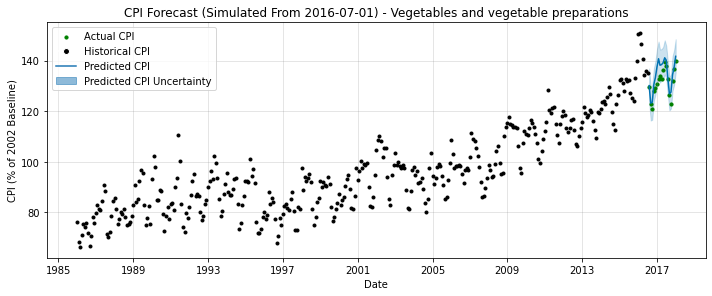

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score     0.570
mae          2.895
mape         0.022
mse         12.960
rmse         3.600
dtype: float64
Initial log joint probability = -3.6296
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1062.05    0.00271072       71.3822           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       1062.17   0.000625412       205.396   7.594e-06       0.001      154  LS failed, Hessian reset 
     164       1063.41   0.000383334       152.882   3.907e-06       0.001      269  LS failed, Hessian reset 
     199       1063.84   0.000294906       78.5975      0.1525      0.6828      311   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     298       1064.48   0.000239232       109.007   3.292e-06       0.001      465  LS failed, Hessian reset 
     299       1064.49   0.000134808        71.796           1     

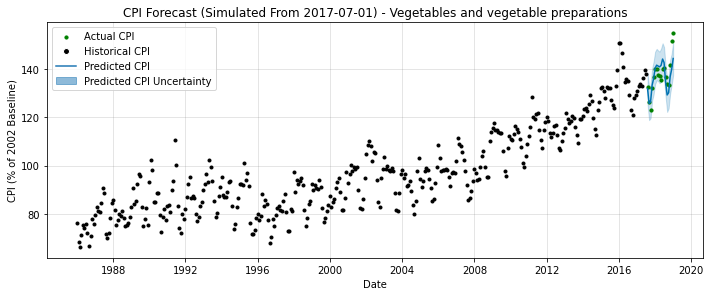

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score     0.577
mae          3.638
mape         0.026
mse         23.174
rmse         4.814
dtype: float64
Initial log joint probability = -3.70272
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1099.88      0.018199       185.811           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175        1101.8   0.000300117       124.864   4.078e-06       0.001      259  LS failed, Hessian reset 
     199       1101.98   0.000238448        69.816           1           1      287   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       1102.05   0.000160484       78.8121   1.633e-06       0.001      350  LS failed, Hessian reset 
     299        1102.1   2.10342e-06       54.0035      0.2766           1      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes

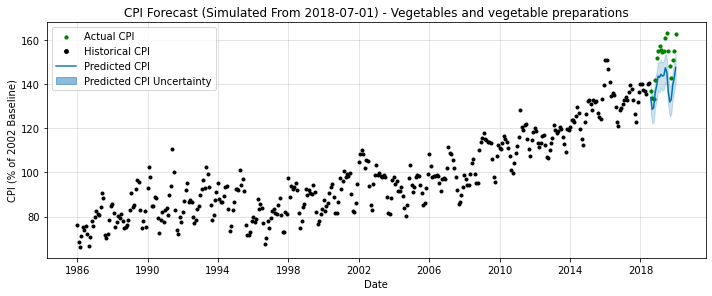

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score     -0.772
mae          11.269
mape          0.074
mse         146.061
rmse         12.086
dtype: float64
Initial log joint probability = -6.20023
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1155.62     0.0012178       136.809      0.7638      0.7638      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       1156.33   0.000215635       115.426    2.53e-06       0.001      212  LS failed, Hessian reset 
     199       1156.91   0.000343704       64.2625      0.1127           1      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       1156.91   0.000227982       59.2265   3.548e-06       0.001      322  LS failed, Hessian reset 
     265       1157.36   0.000127207       69.9173   1.211e-06       0.001      482  LS failed, Hessian reset 
     299       1157.64    0.00070126       54.1467           

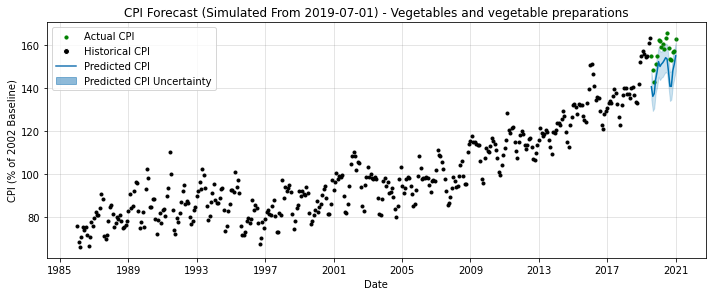

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


r2_score    -2.031
mae          9.397
mape         0.060
mse         95.347
rmse         9.765
dtype: float64
Initial log joint probability = -6.06447
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1189.53    0.00127167       81.9036      0.2019      0.6767      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     192       1192.49   0.000241254       107.137   2.235e-06       0.001      282  LS failed, Hessian reset 
     199        1192.7   0.000549262       169.811           1           1      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1193.21    0.00045397       77.0682      0.2087           1      421   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     318       1193.23   0.000180991       83.6082   2.506e-06       0.001      491  LS failed, Hessian reset

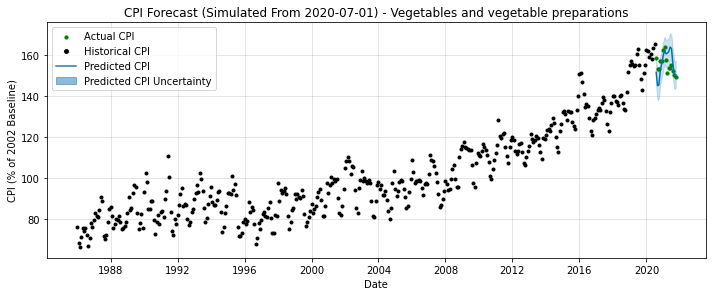

r2_score    -1.250
mae          5.116
mape         0.033
mse         37.215
rmse         6.100
dtype: float64


In [11]:
all_valid_metrics = {}
all_forecasts = {}

for food_category in foodprice_categories:
    
    """
    Iterate over each of the food price categories.
    """

    annual_valid_metrics = {}
    annual_forecasts = {}

    for date in cutoff_dates:
        
        """
        Iterate over each of the cutoff dates. 
        """

        train_dates = sim_train_dates[date]
        valid_dates = sim_valid_dates[date]

        model, valid_forecast, valid_metrics = fit_eval_forecast_model(foodprice_df, food_category, train_dates, valid_dates)
        valid_actual = get_prophet_df(foodprice_df, food_category, valid_dates) 

        plot_valid_forecast(model, food_category, date, valid_forecast, valid_actual)
        valid_metrics_series = pd.Series(valid_metrics)
        print(valid_metrics_series)

        annual_valid_metrics[date] = valid_metrics_series
        annual_forecasts[date] = valid_forecast.yhat

    all_valid_metrics[food_category] = annual_valid_metrics
    all_forecasts[food_category] = annual_forecasts

### View Raw Evaluation Metrics

View all evaluation metrics for one target category, over each of the cutoff dates.

In [24]:
food_category = 'Vegetables and vegetable preparations'
pd.DataFrame(all_valid_metrics[food_category]).T

,r2_score,mae,mape,mse,rmse
2015-07-01,-0.302,7.595,0.055,102.481,10.123
2016-07-01,0.570,2.895,0.022,12.960,3.600
2017-07-01,0.577,3.638,0.026,23.174,4.814
2018-07-01,-0.772,11.269,0.074,146.061,12.086
2019-07-01,-2.031,9.397,0.060,95.347,9.765
2020-07-01,-1.250,5.116,0.033,37.215,6.100


### Collect Mean Validation Metrics Over Cutoff Dates and Save to File

In [19]:
mean_valid_metrics = {}
for food_category, valid_scores in all_valid_metrics.items():
    mean_valid_metrics[food_category] = pd.DataFrame(valid_scores).mean(axis=1)

mean_valid_metrics_df = pd.DataFrame(mean_valid_metrics).T
mean_valid_metrics_df.to_csv(f"{output_path}/mean_fc_valid_metrics.csv")
mean_valid_metrics_df

,r2_score,mae,mape,mse,rmse
Bakery and cereal products (excluding baby food),-13.118,4.121,0.027,26.084,4.508
Dairy products and eggs,-10.463,4.294,0.031,24.726,4.603
"Fish, seafood and other marine products",-1.693,2.689,0.019,10.358,3.052
Food purchased from restaurants,-0.363,1.877,0.012,5.358,2.002
Food,-1.331,2.032,0.014,5.340,2.205
"Fruit, fruit preparations and nuts",-1.935,4.759,0.035,33.454,5.445
Meat,-21.175,5.939,0.037,50.084,6.406
Other food products and non-alcoholic beverages,-2.964,1.701,0.012,4.393,2.001
Vegetables and vegetable preparations,-0.535,6.652,0.045,69.540,7.748


## Save Validation Forecasts to File (Optional, For Ensembling)

In [ ]:
date_forecasts = {}
for date in cutoff_dates:
    valid_dates = sim_valid_dates[date]
    food_forecasts = {}
    for food_category in foodprice_categories:
        food_forecasts[food_category] = all_forecasts[food_category][date]
    date_forecasts[date] = pd.DataFrame(food_forecasts)
    date_forecasts[date] = date_forecasts[date].set_index(pd.DatetimeIndex(valid_dates))
    date_forecasts[date].to_csv(f"{output_path}/forecasts_{date}.csv")